In [2]:
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import numpy as np
from iminuit import minuit
from iminuit.cost import LeastSquares
import pandas as pd
from scipy import constants

matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
parent = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\IR_KIDS_CHAR\2o raff\RES_DATA'

In [4]:
data = pd.read_csv(parent+r'\RES0.txt', sep='\t')

In [226]:
def resonance_model(f, pars):
    x = (f-pars[3])/pars[3]
    return 1-(pars[0]/pars[1])*(np.exp(1j*pars[2])/(1+1j*2*x*pars[0]))

polyorder = 2

def model(x, *pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return pol*np.abs(res)

def phase(x,*pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return np.unwrap(np.angle(1j*res.imag+res.real+pol))

In [227]:
F = data['F']
I = data['I']
Q = data['Q']

In [228]:
F = np.array(F)+5.342*1e9
C = np.array(Q)+1j*np.array(I)
A = np.abs(C)
P = np.unwrap(np.angle(C))

Text(0, 0.5, '$\\phi$ [rad]')

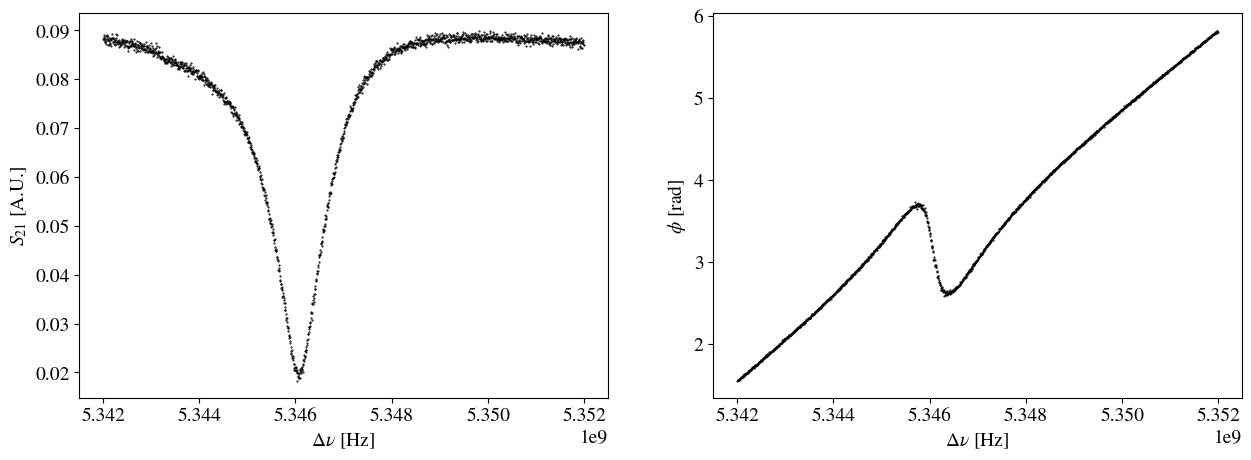

In [229]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')

In [230]:
A = 20*np.log10(np.sqrt(A))
#F = (F - F[np.argmin(A)])/F[np.argmin(A)]
a = np.polyfit(F,P,1)
P = P - np.polyval(a,F)
len_fit = int(np.floor(len(A)/10))
pol_amp = np.polyfit(F[:len_fit], A[:len_fit], 2)
A_rms = np.sqrt(np.mean((np.polyval(pol_amp, F[:len_fit])-A[:len_fit])**2))   

In [231]:
pol_ph = np.polyfit(F[:len_fit], P[:len_fit], 2)
P_rms = np.sqrt(np.mean((np.polyval(pol_ph, F[:len_fit])-P[:len_fit])**2))

In [232]:
p0 = [1e-20,1e-15,-11,7e3,9e3,3.2,5.346*1e9]

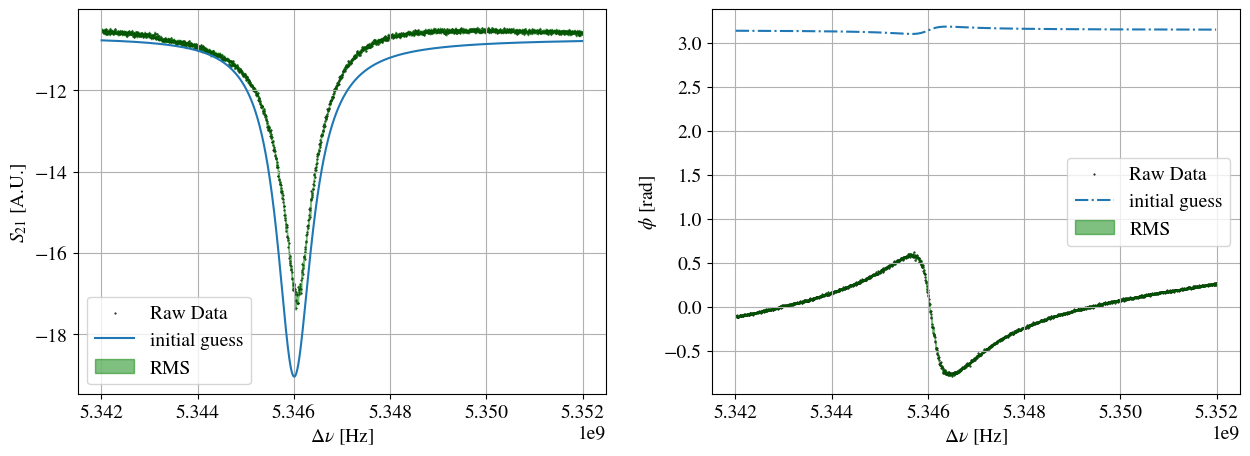

In [233]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F,model(F,*p0), label='initial guess')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].plot(F,phase(F,*p0),linestyle='-.', label='initial guess')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

In [239]:
lsq = LeastSquares(F,A,A_rms*np.ones(len(A)),model)
m= minuit.Minuit(lsq, *p0)
m.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.521e+05 (χ²/ndof = 535.2)│             Nfcn = 36973             │
│ EDM = 2.4e+12 (Goal: 0.0002)     │           time = 17.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  0.4e-18  │  2.0e-18  │            │            │         │         │       │
│ 1 │ x1   │-34.75e-12 │ 0.10e-12  │            │            │         │         │       │
│ 2 │ x2   │ -11.5240  │  0.0006   │            │            │         │         │       │
│ 3 │ x3   │ 19.155e3  │  0.031e3  │            │            │         │         │       │
│ 4 │ x4   │  84.5e3   │   0.5e3   │            │            │         │         │       │
│ 5 │ x5   │  2.8554   │  0.0009   │            │            │         │         │       │
│ 6 │ x6   │5.34610413e9│0.00000030e9│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                      x0                      x1                      x2                      x3                      x4                      x5                      x6 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │                4.01e-36                 152e-36      -757.435418854e-27  -2.261026943317944e-21 -57.839697725445760e-21      -374.606528293e-27 248.790378661387933e-21 │
│ x1 │                 152e-36                1.06e-26       -47.134868101e-18     71.283278802909e-15 -10.386056516236803e-12         6.111419894e-18  -1.674498754304469e-12 │
│ x2 │      -757.435418854e-27       -47.134868101e-18                3.69e-07                835.5e-6            -128.2961e-3                  0.1e-6             -21.7034e-3 │
│ x3 │  -2.261026943317944e-21     71.283278802909e-15                835.5e-6                     959                  -0.5e3               5.5654e-3                  -1.7e3 │
│ x4 │ -57.839697725445760e-21 -10.386056516236803e-12            -128.2961e-3                  -0.5e3                2.05e+05            -116.1003e-3                  0.03e6 │
│ x5 │      -374.606528293e-27         6.111419894e-18                  0.1e-6               5.5654e-3            -116.1003e-3                8.45e-07            -165.8318e-3 │
│ x6 │ 248.790378661387933e-21  -1.674498754304469e-12             -21.7034e-3                  -1.7e3                  0.03e6            -165.8318e-3                9.17e+04 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [240]:
lsqp = LeastSquares(F,P,P_rms*np.ones(len(P)),phase)
mp = minuit.Minuit(lsqp, *p0)
mp.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.521e+05 (χ²/ndof = 535.2)│             Nfcn = 36973             │
│ EDM = 2.4e+12 (Goal: 0.0002)     │           time = 15.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  0.4e-18  │  2.0e-18  │            │            │         │         │       │
│ 1 │ x1   │-34.75e-12 │ 0.10e-12  │            │            │         │         │       │
│ 2 │ x2   │ -11.5240  │  0.0006   │            │            │         │         │       │
│ 3 │ x3   │ 19.155e3  │  0.031e3  │            │            │         │         │       │
│ 4 │ x4   │  84.5e3   │   0.5e3   │            │            │         │         │       │
│ 5 │ x5   │  2.8554   │  0.0009   │            │            │         │         │       │
│ 6 │ x6   │5.34610413e9│0.00000030e9│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                      x0                      x1                      x2                      x3                      x4                      x5                      x6 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │                4.01e-36                 152e-36      -757.435418854e-27  -2.261026943317944e-21 -57.839697725445760e-21      -374.606528293e-27 248.790378661387933e-21 │
│ x1 │                 152e-36                1.06e-26       -47.134868101e-18     71.283278802909e-15 -10.386056516236803e-12         6.111419894e-18  -1.674498754304469e-12 │
│ x2 │      -757.435418854e-27       -47.134868101e-18                3.69e-07                835.5e-6            -128.2961e-3                  0.1e-6             -21.7034e-3 │
│ x3 │  -2.261026943317944e-21     71.283278802909e-15                835.5e-6                     959                  -0.5e3               5.5654e-3                  -1.7e3 │
│ x4 │ -57.839697725445760e-21 -10.386056516236803e-12            -128.2961e-3                  -0.5e3                2.05e+05            -116.1003e-3                  0.03e6 │
│ x5 │      -374.606528293e-27         6.111419894e-18                  0.1e-6               5.5654e-3            -116.1003e-3                8.45e-07            -165.8318e-3 │
│ x6 │ 248.790378661387933e-21  -1.674498754304469e-12             -21.7034e-3                  -1.7e3                  0.03e6            -165.8318e-3                9.17e+04 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

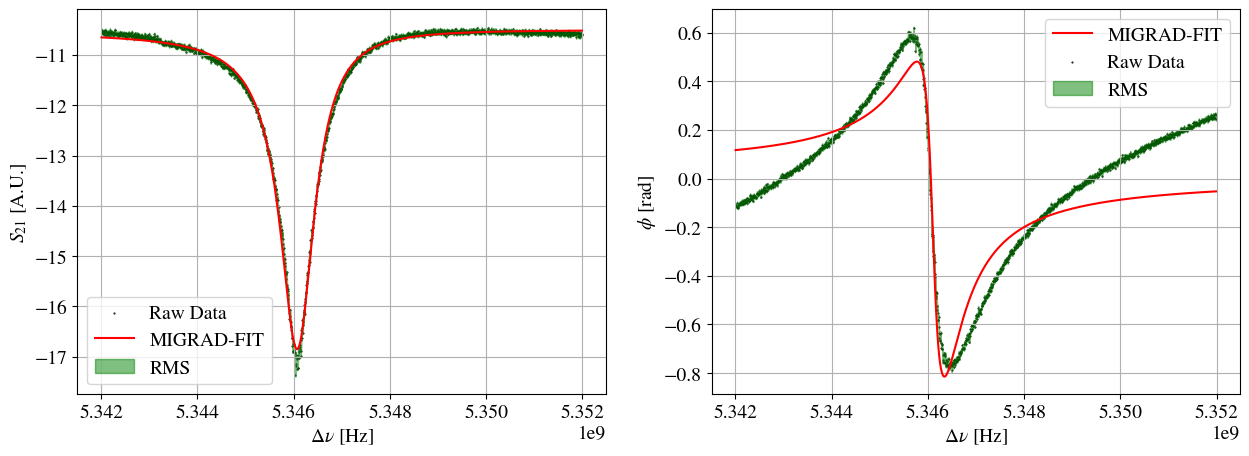

In [241]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F, model(F,*m.values), color='red',label='MIGRAD-FIT')
axs[1].plot(F, phase(F,*mp.values), color='red',label='MIGRAD-FIT')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

In [243]:
print('Q(S21) = ', m.values[3])
print('Q(phase) = ', mp.values[3])
print('Q_c(S21) = ', m.values[4])
print('Q_c(phase) = ', mp.values[4])

Q(S21) =  6846.2975939206535
Q(phase) =  19155.101566933823
Q_c(S21) =  11359.45021145358
Q_c(phase) =  84481.48830402206


In [245]:
Qi = (m.values[3]**(-1)+m.values[4]**(-1))**(-1)
print('Qi(S21) = ',Qi)

Qi(S21) =  4271.737556859861
